In [18]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("HospitalDataAnalysis").getOrCreate()
df = spark.read.csv("hospital data analysis.csv", header=True, inferSchema=True)
df.show(5)


+----------+---+------+-------------+--------------------+-----+--------------+-----------+---------+------------+
|Patient_ID|Age|Gender|    Condition|           Procedure| Cost|Length_of_Stay|Readmission|  Outcome|Satisfaction|
+----------+---+------+-------------+--------------------+-----+--------------+-----------+---------+------------+
|         1| 45|Female|Heart Disease|         Angioplasty|15000|             5|         No|Recovered|           4|
|         2| 60|  Male|     Diabetes|     Insulin Therapy| 2000|             3|        Yes|   Stable|           3|
|         3| 32|Female|Fractured Arm|    X-Ray and Splint|  500|             1|         No|Recovered|           5|
|         4| 75|  Male|       Stroke|CT Scan and Medic...|10000|             7|        Yes|   Stable|           2|
|         5| 50|Female|       Cancer|Surgery and Chemo...|25000|            10|         No|Recovered|           4|
+----------+---+------+-------------+--------------------+-----+--------------+-

In [19]:
from pyspark.ml.feature import StringIndexer

for col in ["Gender", "Condition", "Procedure", "Readmission", "Outcome"]:
    indexer = StringIndexer(inputCol=col, outputCol=col+"_Index")
    df = indexer.fit(df).transform(df)


In [20]:
df.groupBy("Condition").count().orderBy("count", ascending=False).show()


+--------------------+-----+
|           Condition|count|
+--------------------+-----+
|        Heart Attack|   67|
|       Fractured Leg|   67|
|              Stroke|   66|
|   Allergic Reaction|   66|
|        Hypertension|   66|
|       Fractured Arm|   66|
|              Cancer|   66|
|        Appendicitis|   66|
|       Heart Disease|   65|
|            Diabetes|   65|
|Respiratory Infec...|   65|
|       Kidney Stones|   65|
|          Childbirth|   65|
|     Prostate Cancer|   65|
|      Osteoarthritis|   64|
+--------------------+-----+



In [21]:
df.groupBy("Procedure").avg("Cost").show()


+--------------------+---------+
|           Procedure|avg(Cost)|
+--------------------+---------+
|Cardiac Catheteri...|  18000.0|
|Physical Therapy ...|   4000.0|
|Surgery and Chemo...|  25000.0|
|CT Scan and Medic...|  10000.0|
|Delivery and Post...|  12000.0|
|     Insulin Therapy|   2000.0|
|Cast and Physical...|   3000.0|
|Medication and Co...|   1000.0|
|Epinephrine Injec...|    100.0|
|        Appendectomy|   8000.0|
|         Angioplasty|  15000.0|
|    X-Ray and Splint|    500.0|
|         Lithotripsy|   6000.0|
|Antibiotics and Rest|    800.0|
|   Radiation Therapy|  20000.0|
+--------------------+---------+



In [29]:
from pyspark.sql.functions import col

# Most common conditions
df.groupBy("Condition").count().orderBy(col("count").desc()).show()


+--------------------+-----+
|           Condition|count|
+--------------------+-----+
|        Heart Attack|   67|
|       Fractured Leg|   67|
|              Stroke|   66|
|   Allergic Reaction|   66|
|        Hypertension|   66|
|       Fractured Arm|   66|
|              Cancer|   66|
|        Appendicitis|   66|
|       Heart Disease|   65|
|            Diabetes|   65|
|Respiratory Infec...|   65|
|       Kidney Stones|   65|
|          Childbirth|   65|
|     Prostate Cancer|   65|
|      Osteoarthritis|   64|
+--------------------+-----+



In [22]:
df.groupBy("Condition", "Readmission").count().show()


+--------------------+-----------+-----+
|           Condition|Readmission|count|
+--------------------+-----------+-----+
|            Diabetes|         No|   64|
|            Diabetes|        Yes|    1|
|        Hypertension|         No|   66|
|       Kidney Stones|         No|   65|
|      Osteoarthritis|         No|   64|
|              Cancer|         No|   33|
|       Heart Disease|         No|    1|
|       Fractured Leg|         No|   67|
|              Cancer|        Yes|   33|
|       Fractured Arm|         No|   33|
|        Heart Attack|        Yes|   67|
|              Stroke|        Yes|   33|
|        Appendicitis|         No|   33|
|     Prostate Cancer|         No|   65|
|   Allergic Reaction|         No|   66|
|       Heart Disease|        Yes|   64|
|        Appendicitis|        Yes|   33|
|              Stroke|         No|   33|
|Respiratory Infec...|         No|   65|
|          Childbirth|         No|   65|
+--------------------+-----------+-----+
only showing top

In [23]:
from pyspark.sql.functions import when, col

df = df.withColumn("AgeGroup", 
                   when(col("Age") < 18, "Child")
                   .when((col("Age") >= 18) & (col("Age") < 40), "Adult")
                   .when((col("Age") >= 40) & (col("Age") < 60), "Middle-aged")
                   .otherwise("Senior"))

df = df.withColumn("CostPerDay", col("Cost") / col("Length_of_Stay"))


In [24]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

assembler = VectorAssembler(
    inputCols=["Age","Gender_Index","Condition_Index","Procedure_Index","Cost",
               "Length_of_Stay","Outcome_Index","Satisfaction"],
    outputCol="features")

data = assembler.transform(df)

# Train-test split
train, test = data.randomSplit([0.7,0.3], seed=42)

rf = RandomForestClassifier(labelCol="Readmission_Index", featuresCol="features")
model = rf.fit(train)

predictions = model.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol="Readmission_Index")
print("Accuracy:", evaluator.evaluate(predictions))


Accuracy: 0.9963358070500928


In [25]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=3, seed=1, featuresCol="features")
model = kmeans.fit(data)
clusters = model.transform(data)
clusters.groupBy("prediction").count().show()


+----------+-----+
|prediction|count|
+----------+-----+
|         1|  459|
|         2|  262|
|         0|  263|
+----------+-----+



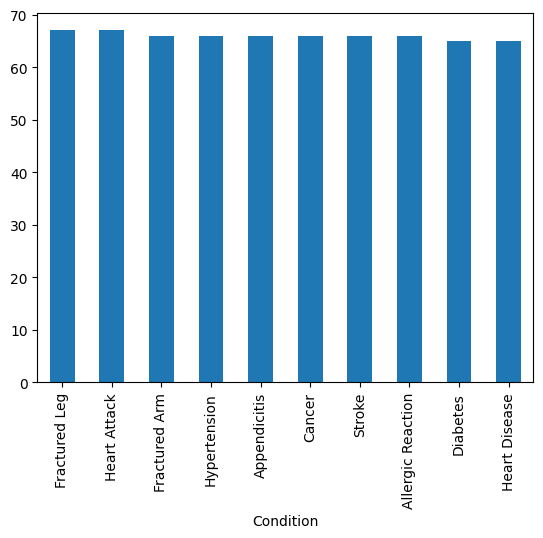

In [26]:
import matplotlib.pyplot as plt

pandas_df = df.toPandas()
pandas_df['Condition'].value_counts().head(10).plot(kind='bar')
plt.show()
